# HW 4 - Supervised Learning at Scale.
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In the first three homeworks you became familiar with the Map-Reduce programming paradigm as manifested in the Hadoop Streaming and Spark frameworks. We explored how different data structures and design patterns can help us manage the computational complexity of an algorithm. As part of this process you implemented both a supervised learning alogorithm (Naive Bayes) and an unsupervised learning algorithm (synonym detection via cosine similarity). In both of these tasks parallelization helped us manage calculations involving a large number of features. However a large feature space isn't the only situation that might prompt us to want to parallelize a machine learning algorithm. In the final two assignments we'll look at cases where the iterative nature of an algorithm is the main driver of its computational complexity (and the reason we might want to parallelize it).

In this week's assignment we'll perform 3 kinds of linear regression: OLS, Ridge and Lasso. As in previous assignments you will implement the core calculations using Spark RDDs... though we've provided more of a code base than before since the focus of the latter half of the course is more on general machine learning concepts. By the end of this homework you should be able to:  
* ... __define__ the loss functions for OLS, Ridge and Lasso regression.
* ... __calculate__ the gradient for each of these loss functions.
* ... __identify__ which parts of the gradient descent algorithm can be parallelized.
* ... __implement__ parallelized gradient descent with cross-validation and regularization.
* ... __compare/contrast__ how L1 and L2 regularization impact model parameters & performance.

Additional Reference: [Spark 2.2 Documentation - RDD programming guide](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html)

__Please refer to the `README` for homework submission instructions and additional resources.__ 

### Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER:`__ If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Question 1: Opimization Theory 

As you know from w207, Gradient Descent is an iterative process that seeks to find the optimal parameters for a model given a particular training data set. It does this by using the vector of partial derivatives of a loss function to strategically update parameters in a way that will reduce the loss. In live session 6 you discussed some of the theory behnid why gradient descent works and looked at a small example of gradient descent in the context of linear regression.

### Q1 Tasks:

* __a) short response:__ What are the first and second order conditions for convexity and why do we care about them when performing Gradient Descent?

* __b) short response:__ Explain the relationship between problem domain space and model parameter space in the context of Gradient Descent. In practice, why can't we find the optimal model by simply looking at the error surface in model parameter space?

* __c) short response:__ In the context of Gradient Descent, what is the 'learning rate' and what are the tradeoffs associated with setting this hyperparameter?

* __d) BONUS:__ In the context of OLS, what do we mean by a 'closed form solution' and why is it not scalable?

### Q1 Student Answers:
> __a)__ The first order condition for convexity states the tangent line for any point on a complex function must have points less than or equal to the function. In other words, these tangent lines are all below the convex function.  Furthermore the minimum of a convex function must occur at a point where the derivative (or gradient in the case of multi-variate function) is equal to 0.  The second order condition for convexity is that the second derivative for all points in a convex region must be greater than or equal to 0.  When performing gradient descent, the gradients calculated from each model version is used to create the next model version, with the eventual goal of finding optimized parameters that minimize the loss.  By taking steps negative to the gradient, we are moving towards a minimum in the loss function.  If the loss function is convex, then we are guaranteed that any minimum we reach is also a global minimum.  In reaching the global minimum of the loss function in this method, we can succeed in finding the best possible parameters for our model.  

> __b)__ The problem domain space is constructed by the dimensions which correspond to the features.  Given a set of data with n features, the problem domain space would consist of n dimensions, where each axis corresponds to a feature with a domain that matches the range of data for that feature.  The problem domain space is therefore the space used to represent the actual data and most machine learning problems have the objective of finding a model that exists in the problem domain space.  The model parameter space is constructed by dimensions that correspond to each possible parameter of the model.  The axis of the parameter space corresponds to a parameter in the model with a domain that matches the range of all possible parameter values.  In practice, we cannot find the optimal model by simply looking at the error surface of the model parameter space because it is not easily constructable for all models and sometimes impractical.  An error surface is created from calculating the loss of every possible combination of parameters in a region of the parameter space.  This may be simple to do for a model with 2, maybe 3 parameters.  However, for more complex models made of many more parameters, the calculation of loss for all possible combination of parameters becomes a tedious and unscalable task.  

> __c)__ In gradient descent, the learning rate is the size of the step taken negative to the gradient.  In other words, it is a factor by which the gradient changes the existing model to produce the new model.  The learning rate therefore controls the speed at which we find the mininmum in the gradient descent method.  The trade off is that a very small learning rate can guarantee that we do not miss finding the minimum loss but will be much slower since the process to reach the minimum will take more steps and more time.  A very large learning rate can transform the model so quickly that the loss function minimum is missed and completely overstepped.  If the gradient descent method oversteps the minimum, it will lead to movement away from the minimum and an increase in loss, resulting in a much worse model than the original baseline. 

> __d)__ The closed form solution of linear regression uses the following equation to calculate the parameter vector, $\theta = (X^TX)^{-1}X^Ty$, where X is the matrix representation of the data and y is the vector of the outcome values.  Each row in X is a features vector and each column corresponds to a feature.  The reason this is not scalable is because of the caclulation of the inverse matrix $(X^TX)^{-1}$ is very complex and will only increase in complexity as the data set increases either in features number or the number of data points.  In addition, the process of matrix multiplication, although parallelizable, can also be costly and does not scale well for large data sets and/or large number of features. 

# About the Data

For the main task in this portion of the homework you will use data about red and white Portuguese wines. [This data](http://archive.ics.uci.edu/ml/datasets/Wine+Quality) was made available to the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with [this paper](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub):
> P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

The dataset includes 12 fields:
>`fixed acidity`  
`volatile acidity`  
`citric acid`  
`residual sugar`  
`chlorides`  
`free sulfur dioxide`  
`total sulfur dioxide`  
`density`  
`pH`  
`sulphates`  
`alcohol`  
`quality`   -- (_a score between 0 and 10_)

__`IMPORTANT NOTE:`__ The outcome variable in our data is a human assigned score ranging from 0 to 10. Since the scores are integers this is actually an ordinal and not numerical outcome varaible. However for the purposes of this assignment we'll treat it as a numerical quantity.

The data are in two files: one containing red wines and another containing white wines.  Use the following cells to download the data, add a field for red/white, and split it into a test and train set.

In [5]:
# make a data folder & download red & white wine files
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [5]:
# extract header fields - RUN THIS CELL AS IS
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [6]:
# load the raw data into an RDD - RUN THIS CELL AS IS
redsRDD = sc.textFile('data/reds.csv')\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
whitesRDD = sc.textFile('data/whites.csv')\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine

In [7]:
# Generate 80/20 (pseudo)random train/test split - RUN THIS CELL AS IS
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 1316 records for evaluation and assigned 5181 for training.


In [8]:
# helper function - RUN THIS CELL AS IS
def parse(line):
    """
    Map record_csv_string --> (tuple,of,fields)
    """
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [9]:
# cache the training set - RUN THIS CELL AS IS 
trainRDDCached = trainRDD.map(parse).cache()

# Question 2: EDA

A statistician's approach to Linear Regression typically involves a series of EDA steps to examine each feature in the data and then series of steps to test assumptions about their potential contribution to a multi-feature linear model. In particular, we'd want to look for a set of features that exhibit a likely linear relationship with the outcome variable and that are _not_ highy correlated with each other. In the context of machine learning, these considerations remain important techniques for improving model generalizability despite the common practice to use model evaluation techniques (and large data sets) to get the final word on feature selection. 

In this question we'll briefly look at the features in our data set. To mimic an 'at scale' analysis we'll start by sampling from our Spark RDD training set so that we have a manageable amount of data to work with in our visuals.

### Q2 Tasks:
* __a) short response:__ Run the provided code to sample 1000 points and visualize histograms of each feature. Comment on the distributions you observe (eg. _Which features appear normaly distributed, which don't? Which features vary most/least?_) How is the varaible `color` different than the other features & what does that mean about how we interpret its regression coefficient?

* __b) short response:__ Run the provided code to create boxplots of each feature. Which, if any, appear to have a positive linear relationship with `quality`? Which if any appear to have a negative linear relationship with `quality`?


* __c) short response:__ Run the provided code to plot the correlations matrix. Which pairs of features are most _strongly_ (postively or negatively) associated with each other? What implications would that have for our feature selection?

### Q2 Student Answers:
> __a)__ Based on the histograms, only the pH and density features appear to have normal distributions.  The citric acid feature appears close to a normal distribution except for a few outliers to the right.  All other features appear to have right skew in their distributions.  For features that vary the least, I look at the distributions with the smallest domain widths.  These features include chlorides (0 to 0.6), citric acid (0 to 1), volatile acidity (0 to 1.2) and density (0.895 to 1.005).  By contrast, features that vary the most are free sulfur dioxide (0 to 300) and total sulfur dioxide (0 to 400). The color feature's distribution is strange because there are only 2 bars, since the color can only take on one of two values, 0 representing white and 1 representing red.  The color variable is an indicator variable, rather than a numeric variable like all the other features.  The model regression coefficient for color would represent the average difference in quality between red and white wines if all other variables were constant. 

> __b)__ When looking at the box plot graphs, I use the positions of the medians in each box plot to determine whether or not the relationships are positive or negative.  Most features when plotted with quality have box plot medians that are completely aligned, which makes the relationship inconclusive from viewing the plot alone.  The only definitive positive relationship is between quality and alcohol, since quality increase is clearly associated with an increase in alcohol median value.  The only relationship that is definitively negative is that between quality and density.  An increase in quality is associated with a decrease in median density.  

> __c)__ Pairs with the strongest postive association are volatile acidity with color and total sulfur dioxide with free sulfur dioxide.  Feature pairs with the strongest negative association are total sulfur dioxide with color and density with alcohol.  In linear regression modeling, multicolinearity, or high linear correlation between multiple explanatory variables will lead to less precise estimates for these variables' model coefficients. In addition, variables that are highly correlated contain the same information regarding the outcome variable, or they explain the variation in the outcome variable in the same way.  Therefore, when selecting features to include in model construction, it may be unwise to include highly correlated variables as explanatory variables in the same model.  

In [10]:
# part a - take a 1000 point sample for EDA (RUN THIS CELL AS IS)
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

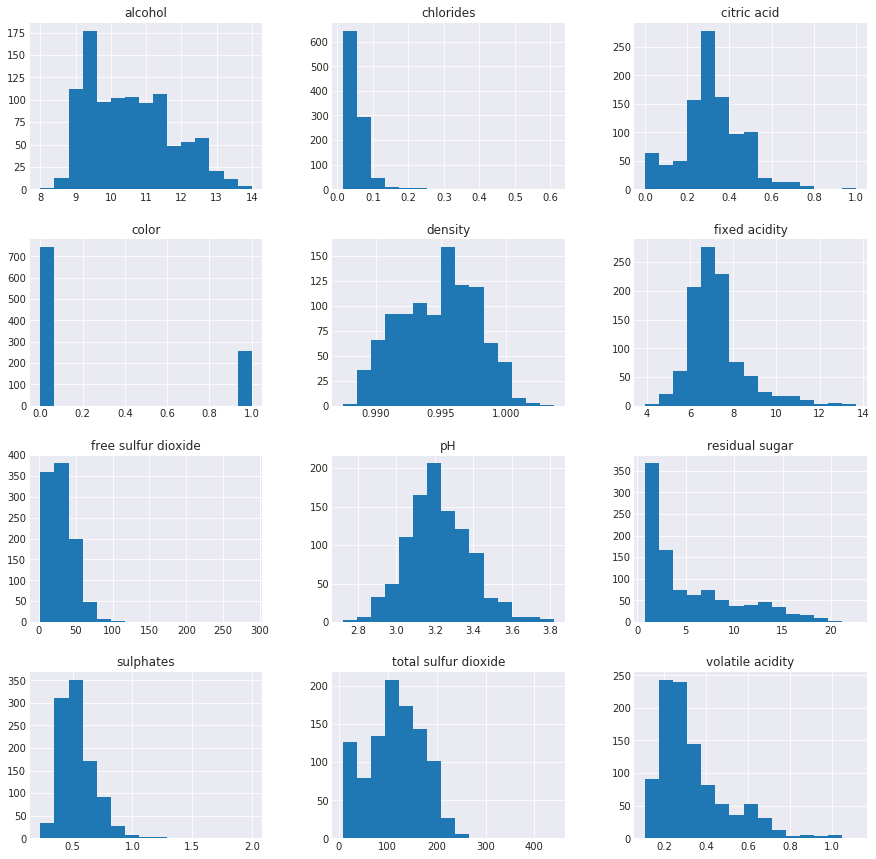

In [11]:
# part a - take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_df[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

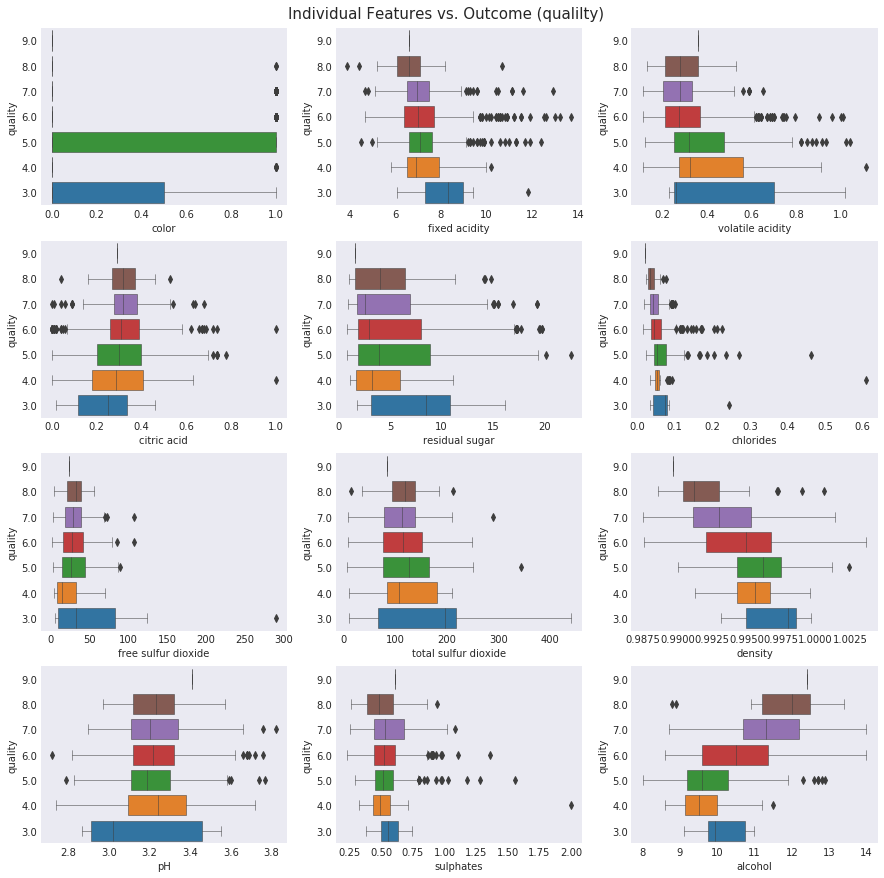

In [12]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)
fig, ax_grid = plt.subplots(4, 3, figsize=(15,15))
y = sample_df['quality']
for idx, feature in enumerate(FIELDS[:-1]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

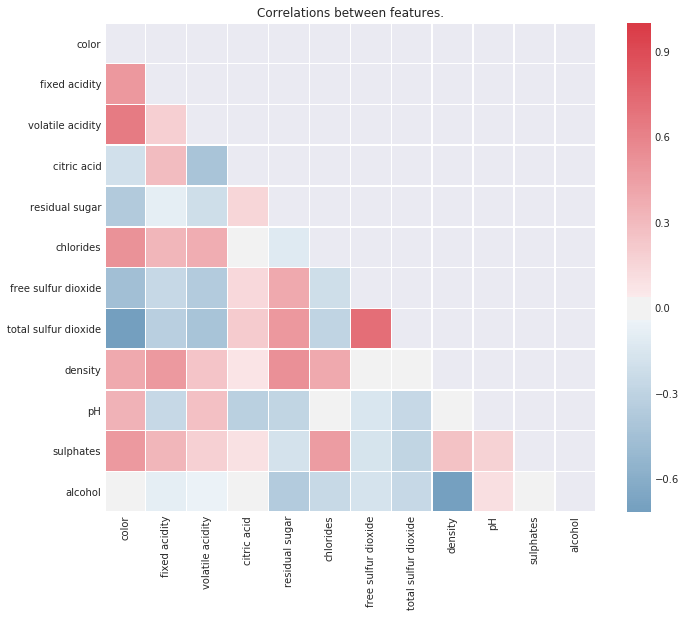

In [13]:
# plot heatmap for correlations matrix - RUN THIS CELL AS IS
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

# Question 3: OLS Loss

For a parametric model, the key factor that will impact how easy it is to optimize is your choice of how to define the loss function. In Ordinary Least Squares (OLS) Regression our loss function is just about as convenient as you will get: not only is it convex, its also very easy to interpret. In this question you'll "choose" a baseline model and then write a function to compute the loss of a linear model in Spark. You'll reuse this function in Q4 when you implement gradient descent.

### Q3 Tasks:
* __a) code:__ Fill in the code below to compute the mean and variance of your outcome variable. [__`HINT:`__ _use `trainRDDCached` as the input & feel free to use Spark built-in functions._]


* __b) short response:__ Write the formula for the OLS loss function and explain how to interpret it graphically.


* __c) short response:__ In the context of linear models & vector computations what does it mean to 'augment' a data point and why do we do this?


* __d) code + short response:__ Fill in the missing code to complete the`OLSLoss` function. Is computing the loss "embarassingly parallel'? Explain. [__`TIP:`__ Use `augmentedData` as your input when computing the loss.]

* __e) code + short response:__ Fill in the missing code to define a baseline model for this data set that has a bias term equal to the mean of your outcome variable and `0.0` for all coefficients. Note that in the docstring for `OLSLoss` we specified that the model should be a numpy array with the bias in the first position. Once you've defined your model, run the provided cells to check that your model has the correct dimensions and then compute the loss for your baseline model. Compare your results to the result you got in `part a` and explain what you see.

### Q3 Student Answers:
> __b)__ The OLS loss function is $f(\boldsymbol{\theta}) = \frac{1}{n}\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right]^2$.  In this equation, $\boldsymbol{\theta}\cdot\mathbf{x}'$ represents the model predicted outcome value while $y_i$ represents the actual outcome value in the data.  So the graphical interpretation is that for each data point, we calculate the distance between the model and each data point.  These distances are then squared and the average of these squared values represents the OLS loss.  

> __c)__ Augmenting each data point adds an additional element to the features vector with the value of 1.  The 1 is placed in the position of the bias term in the model (also know as the y-intercept term). The purpose of the augmentation allows us to also optimize the bias term in the model in addition to all of the coefficients that correspond to each feature.  

> __d)__ In computing the OLS loss, finding the squared difference between the predicted value and the actual value can be done in parallel, because this calculation can be done for each point independently of all other points.  Since we can perform the squared difference calculation within each partition without needing the results from other paritions, computing the loss is embarassingly parallel.  However, a reduce step is still needed at the end in order to calculate the average of all squared differences. 

> __e)__ When we calculate the loss of the baseline model, we get 0.76, which is equivalent to the variance of the quality variable, which is the outcome variable.  This is expected, since the baseline model has 0s as coefficients for all of the explanatory variables.  The only non-zero value in the baseline model is the quality variable average which serves as the y-intercept or bias term.  The OLS loss calculates the squared difference between each data point and the model, or in this case, the difference between each quality value and the qualtity mean.  The average square of differences between all values and the mean for a single variable is the exact definition of the variance, hence we expect the baseline model loss to be equivalent to the variance. 

In [14]:
# part a - mean and variance of the outcome variable 
meanQuality = trainRDDCached.map(lambda x: x[1]).mean()
varQuality = trainRDDCached.map(lambda x: x[1]).variance()
print(f"Mean: {meanQuality}")
print(f"Variance: {varQuality}")

Mean: 5.811040339702759
Variance: 0.760086564865664


In [15]:
# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def OLSLoss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: np.dot(W, x[0]) - x[1])\
                        .map(lambda x: x**2)\
                        .mean()
    ################## (END) YOUR CODE ##################
    return loss

In [16]:
# part e - define your baseline model here
BASELINE = np.array([meanQuality]+[0 for i in range(12)])

In [17]:
# part e - compute the loss for your baseline model (RUN THIS CELL AS IS)
assert len(BASELINE) == len(trainRDDCached.take(1)[0][0]) + 1, "Double check model dimensions"
print(f"Baseline model loss: {OLSLoss(trainRDDCached, BASELINE)}")

Baseline model loss: 0.7600865648656636


# Question 4: Vanilla Gradient Descent

Performing Gradient Descent technically only requires two steps: 1) _use the current model to calculate the gradient_; 2) _use the gradient to update the current model parameters_. In practice though, we'll want to add a third step which is to compute the loss for our new model so that we can see if its working. In this question you'll implement gradient descent for OLS regression and take a look at a few update steps.

### Q4 Tasks:
* __a) short response:__ Jimi describes the main part of the gradient calculation for OLS Regression using a short mantra: _'the mean of the data weighted by the errors'_. . Write the formula for the gradient and explain how it reflects this phrase. 

* __b) short response:__ Looking at the formula you wrote in `part a`, what parts of this calculation can be parallelized and what has to happen after reducing?


* __c) code:__ Fill in the missing lines in `GDUpdate` to compute the gradient and perform a single update of the model parameters.   
    * __`TIP 1:`__ _remember that the gradient is a vector of partial derivatives, `grad` should be a numpy array_    
    * __`TIP 2:`__ _Spark's built in `mean()` function may help you here_  


* __d) short response:__ Run the provided code to perform 5 steps of Gradient Descent on our data. What is wrong with these results?


* __e) code + short response:__ Fill in the missing code in `normalize` so that this function scales each feature and centers it at 0. Then use the provide code block to rerun your same gradient descent code on the scaled data. Use these results to explain what the problem was in 'd'.
    * __`TIP:`__ _You may find [this brief illustration](https://www.coursera.org/lecture/machine-learning/gradient-descent-in-practice-i-feature-scaling-xx3Da) from Andrew Ng's Coursera helpful._


### Q4 Student Answers:
> __a)__ The gradient formula has the following equation - $\nabla_{\boldsymbol{\theta}} f(\boldsymbol{\theta}) = \frac{2}{n}\,\sum_{i=1}^{n}\left[ \boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i\right] \cdot \mathbf{x}'$.  Each term of the summation contains a features vector $\mathbf{x}'$, multiplied by the factor $\boldsymbol{\theta}\cdot\mathbf{x}'_i - y_i$, which is the error calculated by the difference between actual and predicted outcome values, In this sense, every term of the summation is essential a data point weighted by the error.  The outside of the summation, there is a 2/n term, so this fits the definition of taking an average by dividing by n.  Therefore, the gradient is indeed the average of the data weighted by errors. 

> __b)__ The part that can be parallelized is the computation of the product of each weight (error) and the features vector.  The part that will happen after reducing is the vector addition of all of the vectors that result from the product calculation in order to caculate an average.  

> __c)__ _complete the coding portions of this question before answering d & e_ 

> __d)__ The loss continues to increase and becomes extremely large by step 5.  This is definitely not the desired result of gradient descent where the objective is for each step to result in decreasing loss.  

> __e)__ The problem in d is that without normalization, some features outweigh others in terms of contribution to the gradient and therefore have a greater effect on the way that the model is transformed in each step.  Features that have low ranges and vary the least cause elongation of the error surface along that parameter axis while features that vary the most leads to the opposite effect, where the error surface is squeezed along the axis of the feature.  The ideal path in gradient descent is a straight line towards the error surface minimum, but when there is elongation and squeezing due to lack of normalization, the path of the gradient descent becomes zigzagged.  A zigzagged path has a greater chance of missing the minimum leading the gradient descent method to create models that move away from the minimum and increase the loss.  When the features are normalized, the path of gradient descent is straighter and therefore more likely to reach the minimum.

In [21]:
# part b - function to perform a single GD step
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    
    grad = augmentedData.map(lambda x: (np.dot(W, x[0]) - x[1])*x[0])\
                        .reduce(lambda x,y: x + y)*2/(augmentedData.count())
    
    new_model = W-learningRate*grad
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [22]:
# part c - take a look at a few Gradient Descent steps (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(trainRDDCached, model)
    loss = OLSLoss(trainRDDCached, model)
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 3255.0397706647964
Model: [5.811, -0.009, -0.017, -0.007, 0.002, -0.035, -0.001, 0.167, -0.489, -0.0, 0.0, 0.001, 0.094]
----------
STEP: 2
Loss: 41538896320.900406
Model: [15.998, 0.946, 71.311, 3.109, 3.394, 67.104, 0.517, 372.213, 1469.681, 10.133, 32.587, 5.197, 105.407]
----------
STEP: 3
Loss: 5.321516254246922e+17
Model: [-36732.224, -3790.819, -257459.013, -11294.195, -12193.785, -240557.886, -1880.28, -1359608.579, -5252902.327, -36544.479, -117571.505, -18781.008, -379946.295]
----------
STEP: 4
Loss: 6.817355374095385e+24
Model: [131498780.95, 13574790.866, 921540888.277, 40426173.604, 43645471.549, 861027822.897, 6730358.366, 4867148463.848, 18801163135.814, 130805962.538, 420832007.136, 67225003.981, 1359973545.811]
----------
STEP: 5
Loss: 8.73366388015958e+31
Model: [-470665198626.59, -48587550191.149, -3298412689019.922, -144694834630.26, -156217444459.899, -3081821742976.577, -24089547803.278, -1742069306459

In [23]:
# part d - helper function to normalize the data (FILL IN THE MISSING CODE BELOW)
def normalize(dataRDD):
    """
    Scale and center data round mean of each feature.
    Args:
        dataRDD - records are tuples of (features_array, y)
    Returns:
        normedRDD - records are tuples of (features_array, y)
    """
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    ################ YOUR CODE HERE #############
    normedRDD = dataRDD.map(lambda x: ((x[0]-featureMeans)/featureStdev, x[1]))
    ################ FILL IN YOUR CODE HERE #############
    
    return normedRDD

In [24]:
# part d - cache normalized data (RUN THIS CELL AS IS)
normedRDD = normalize(trainRDDCached).cache()

In [25]:
# part e - take a look at a few GD steps w/ normalized data  (RUN THIS CELL AS IS)
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {OLSLoss(trainRDDCached,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(normedRDD, model)
    loss = OLSLoss(normedRDD, model) 
    print(f"Loss: {loss}")
    print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.7600865648656636
----------
STEP: 1
Loss: 0.655527669170389
Model: [5.811, -0.02, -0.014, -0.045, 0.014, -0.007, -0.035, 0.009, -0.009, -0.054, 0.003, 0.008, 0.078]
----------
STEP: 2
Loss: 0.615059239044261
Model: [5.811, -0.022, -0.014, -0.071, 0.023, -0.006, -0.05, 0.014, -0.021, -0.079, 0.007, 0.024, 0.131]
----------
STEP: 3
Loss: 0.5935522582531458
Model: [5.811, -0.018, -0.01, -0.09, 0.03, 0.002, -0.057, 0.02, -0.032, -0.09, 0.011, 0.04, 0.167]
----------
STEP: 4
Loss: 0.5798853360580277
Model: [5.811, -0.014, -0.006, -0.105, 0.034, 0.012, -0.061, 0.026, -0.04, -0.094, 0.013, 0.054, 0.195]
----------
STEP: 5
Loss: 0.5703196233260645
Model: [5.811, -0.009, -0.003, -0.117, 0.036, 0.024, -0.063, 0.032, -0.047, -0.096, 0.016, 0.066, 0.217]


# Question 5: Assessing the performance of your model.

Printing out the loss as we perform each gradient descent step allows us to confirm that our Gradient Descent code appears to be working, but this number doesn't accurately reflect "how good" our model is. In this question you'll plot error curves for a test and training set in order to discuss model performance. Note that although we split out a test & train set when we first loaded the data... in the spirit of keeping that 20% truly 'held out' until then end of the assignment, we'll make an additional split for the purposes of this question dividing the existing training set into two smaller RDDs.

### Q5 Tasks:
* __a) short response:__ Why doesn't the loss that we printed in Question 4 accurately reflect "how good" our model is? 


* __b) code:__ Since we're going to be running Gradient Descent a number of times let's package it into a function for convenience. Fill in the missing code in `GradientDescent()`, note that the missing code is going to look a lot like the provided code blocks in Q5 -- feel free to use those as a starting point.


* __c) short response:__ Use the provided code to split the normalized data into a test and train set, then run 50 iterations of gradient descent and plot the MSE curves for each. Describe what you see and speculate about why this might be happening.


* __d) short response:__ Note that passing the optional parameter `seed` to the Spark method `randomSplit` allows us to pseudo randomize our test/train split in a way that is replicable. Re-run the code for part 'c but this time in the line where we perform the `normedRDD.randomSplit` change the seed to _`seed = 5`_. What changes in the plot? Repeat for _`seed = 4`_. How does this change your interpret the results you saw in 'c'. What is the more likely explanation?

### Q5 Student Answers:
> __a)__ The loss values printed in Question 4 does not actually indicate that we have reached a minimum in the loss function and therefore cannot tell us how good the model is.  The loss might be decreasing with each step, but the model may actually be terrible.  We are only guaranteed to find the most optimal parameters with finding the minimum loss through gradient descent, and therefore, we only know that a model leading to minimum loss is better than other OLS models with greater loss.  

> __c)__ In 50 steps, the loss function appears to be decreasing for both the test and training set.  The decrease is rapid at first but slows down and exhibits asymptotic behavior after 20 steps.  When the loss function decrease is negligible, it is likely that the gradient descent method has come very close to the absolute minimum of the error function and the model has acheived the best possible parameters.  Based on these plots, it appears that a little over 20 steps is necessary to achieve model optimization give the learning rate of 0.1.  The test loss appears to be consistently greater than the training loss, even the minimum that the test loss function can acheive is slightly greater than that of the minimum of the training loss.  This might be happening due to overfitting.  Training loss less than test loss is an indication that the average errors between the model and the training data is less than that of errors between the model and test data.  This means that the model fits better to the training data than it does to the test data, which means that the model has a harder time generalizing to the test set, which is an indication of overfitting.  

> __d)__ When the random seed is 5, the loss curves for training and test loss are much closer, with test loss initially less than training loss until the curves reach the asymptotic region.  However, when the random seed is 4, the gap between the training loss and test loss curves is much greater than it is when the random seed was 2018.  The more likely explanation may be that the model quality is not consistent across all splits for training and test data.  The seed for randomization determines the sequence of random numbers generated if the randomization is repeated, so when we change the seed, we also change how the data is split.  If the original data is itself not random, as in there is ordering by one or more variables, then randomization using a particular seed will lead to systematic selection of points for the test and training sets.  Each different training set, depending on a particular split, will lead to a different model.   Some splits can lead to a model that has overfitting issues, while other splits can lead to underfitting models.  Therefore, one split version determined by a particular random seed is insifficient for us to access the model quality by comparing test and training loss only once.  


In [26]:
# part b - OLS gradient descent function
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.1, verbose = False):
    """
    Perform nSteps iterations of OLS gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        ############## YOUR CODE HERE #############
        model = GDUpdate(trainRDD, model)
        training_loss = OLSLoss(trainRDD, model)
        test_loss = OLSLoss(testRDD, model)
        ############## (END) YOUR CODE #############
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [27]:
# plot error curves - RUN THIS CELL AS IS
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [28]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 48.133819580078125 seconds


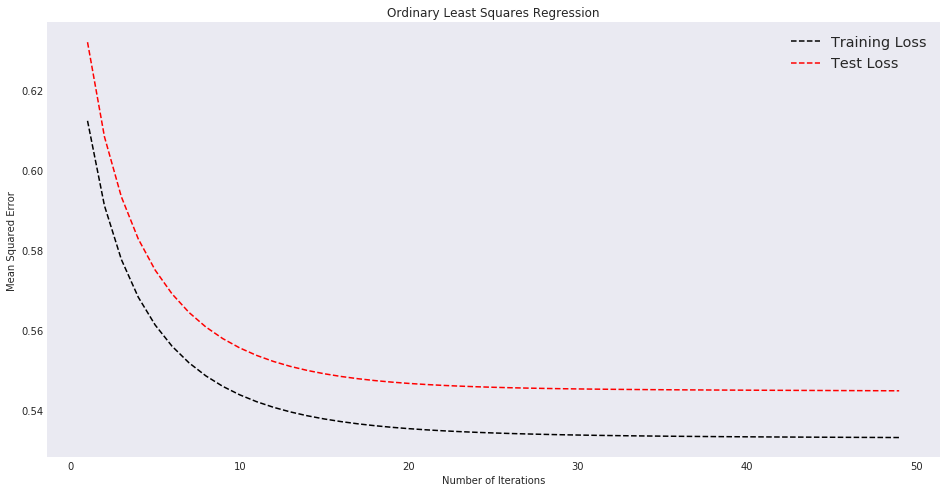

In [29]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [30]:
# save the models & their performance for comparison later (RUN THIS CELL AS IS)
np.savetxt(PWD + '/data/OLSmodels.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/OLSloss.csv', np.array([MSEtrain, MSEtest]), delimiter=',')

In [31]:
#part d - run 50 iterations with random seed = 5
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 51.94220042228699 seconds


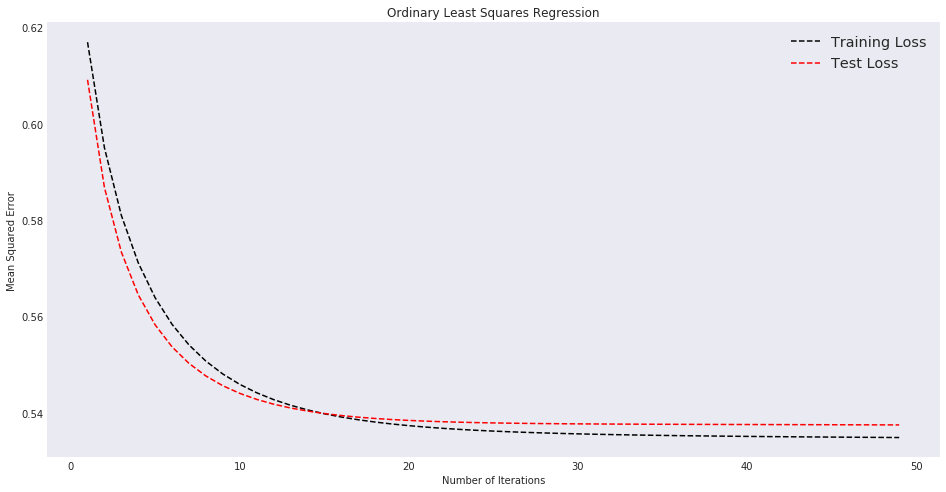

In [32]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

In [33]:
#part d - run 50 iterations with random seed = 4
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 4)
start = time.time()
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 46.193483114242554 seconds


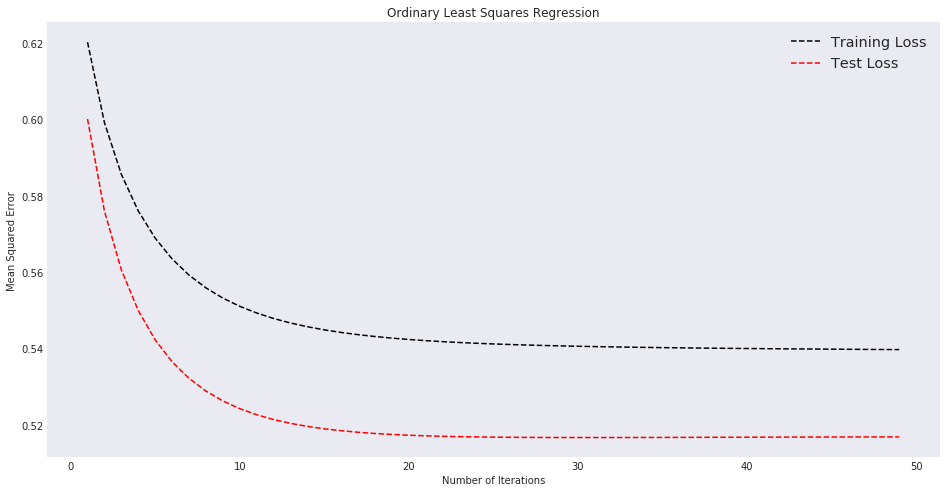

In [34]:
# take a look (RUN THIS CELL AS IS)
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression' )

# Question 6: Cross Validation

In question 5 we mentioned that computing the loss after each iteration is not strictly a part of Gradient Descent, its just convenient for visualizing our progress. This "third step" however comes with a tradeoff: it requires an extra pass through the data. Normally this would cause us to cringe except for the fact that both the loss computation and the gradient computation are very easy to parallelize - lots of the work can be done in place no shuffle needed for the aggregation. 

Cross validation, which will solve the problem of the unreliable test-loss that we saw in question 5, presents a bit more of a scalability challenge. To avoid over-dependence on a particulary good or bad test/train split we divide the data into `k` roughly equal size parts and train `k` models. The `k-th` model is trained on all the data _except_ the `k-th` split which is used as a test set for that model. Finally we compute the loss by averaging together the test/train loss for each model. In this question we've provided a code base to perform gradient descent and cross validation in parallel. You'll fill in some of the key details based on your understanding from questions 1-5.

### Q6 Tasks:
* __a) short response:__ A naive approach to training an OLS Regression model with cross validation might be to simply perform Gradient Descent on each of the 5 models in sequence. In this naive approach, how many total passes would be made over the data? [__`HINT:`__ _it will depend on factors that you should be able to name._]


* __b) short response:__ Read through the provided helper function `kResiduals()` and note where it gets used in the subsequent function `CVLoss()`. For each record in the original dataset, how many tuples does `kResiduals()` emit? What are the keys of these newly emitted records? How will these keys help us compute cross validated loss?


* __c) code:__ Complete the missing Spark code in `CVLoss()` so that this function returns the test/train cross validated error for a give set of data splits and their corresponding models. [__`TIP:`__ _your goal is to start from `partialLossRDD` and compute the test & train loss for each model so that the provided code can take the final average_].


* __d) code:__ Read through the provided functions `partialGradients()` and `CVUpdate()`. These should have a familiar feel. Fill in the missing line in `CVUpdate()` to update each model and add the (new) array of coefficients to the `new_models` list. 


* __e) short response:__ Read `GradientDescent_withCV()` and then run the provided code to perform 50 iterations and plot the error curves. What can you conclude from this graph? 

### Q6 Student Answers:
> __a)__ For each step in gradient desent, we need to pass over the data twice.  Once to augment each of the features vectors and once to perform the vector weighted by error calculation for each point.  Given that the data is split 5 times, the assumption in this naive method is that we will perform the gradient calculation for each of the 5 segments independently, which will allow a pass through all of the data points.  Therefore the total passes is equal to 2 times the number of steps. 

> __b)__ The kResiduals() function emits one tuple per data point, so the number of tuples emitted matches the total number of data points. In cross validation, the data points are split k times and a model is built based on the data from each segment, except for the k-th segment which is used as the test set. The keys emitted is a string consisting of the model number and the word test or train.  Training sets' points would therefore contain "train" in the key and test set points, where the model number matches the number of splits, would therefore contain "test" in the key.  The keys are also model number specific, which is how they help us compute compute cross validation loss.  Emitted key-value pairs with the same key have the same model number in the key.  This ensures that the loss associated with points used to fit the same model are sent to the same reducer in the shuffle. When we are calculating cross validation loss, we first find the average squared error for each of the models, requires that we aggregate squared errors for the subset of points used to fit the same model first.  The key that contains the model number allows us to do this first calculation in the reducing step.  We then are able to calculate the average loss across all k-1 models.  

> __e)__ In this graph, the training loss and test loss are extremely close. We know that the loss curves here are constructed from the average loss of 5 models in each gradient descent iteration. The fact that the test and training loss are so close to each other is a much more desirable result, because a model that can produce the same training loss and test loss does not have overfitting or underfitting. This result could indicates that the best model would be an average model, constructed from many model versions where each version is produced by a different split of the data.  

In [104]:
# part b - helper function to emit residuals (RUN THIS CELL AS IS)
def kResiduals(dataPoint, models, splitNum):
    """
    Compute the (squared) residuals for a data point given k different models.
    Note that points from the k-th split are part of the test set for model number k
    and part of the trainin set for all other models. We'll emit a key to track this.
    Args:
        dataPoint - tuple of (features_array, y)
        models    - list of arrays representing model weights (bias at index 0)
    Returns:
        (stringFormattedKey, squared_error)
    """
    # augment the data point with a bias term at index 0
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit squared residuals for each model
    for modelNum, W in enumerate(models):
        if modelNum == splitNum:
            yield(f"{modelNum}-test", (W.dot(X) - y)**2)
        else:
            yield(f"{modelNum}-train", (W.dot(X) - y)**2)

In [110]:
# part c - fill in the missing code below
def CVLoss(dataSplits, models):
    """
    Compute the k-fold cross-validated test and train loss.
    Args:
        dataSplits - list of RDDs corresponding to the k test splits.
        models     - list of k arrays representing model weights (bias at index 0)
    Returns: 
        tuple of floats: (training_loss, test_loss)
    """
    # compute k residuals for each dataPoint (one for each model)
    partialLossRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        residuals = splitRDD.flatMap(lambda x: kResiduals(x, models, splitNum))
        partialLossRDD = sc.union([partialLossRDD, residuals])
    
    ################ YOUR CODE HERE #################        
    loss = partialLossRDD.map(lambda x: (x[0], (x[1], 1)))\
                         .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))\
                         .mapValues(lambda x: x[0]/x[1])\
                         .collect()
    
    ################ (END) YOUR CODE ################# 
    
    test_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'test'])
    training_loss = np.mean([x[1] for x in loss if x[0].split('-')[1] == 'train'])
    return training_loss, test_loss

In [106]:
# part d - helper function RUN THIS CELL AS IS
def partialGradients(splitNum, dataPoint, models):
    """
    Emit partial gradient for this data point for each model.
    NOTE: a data point from split-number k is in the test set for 
    model-k so we don't compute a partial gradient for that model.
    """
    # augment the data point
    X = np.append([1.0], dataPoint[0])
    y = dataPoint[1]
    # emit partial gradients for each model with a counter for averaging later
    for modelNum, W in enumerate(models):
        if modelNum != splitNum:
            yield (modelNum, [(W.dot(X) - y)*X, 1])

In [107]:
# part d - perform GD updates for all k models (FILL IN MISSING CODE BELOW)
def CVUpdate(dataSplits, models, learningRate = 0.1):
    """
    Compute gradients for k models given k corresponding dataSplits.
    NOTE: the training set for model-k is all records EXCEPT those in the k-th split.
    """
    # compute partial gradient k-1 times for each fold
    partialsRDD = sc.parallelize([])
    for splitNum, splitRDD in enumerate(dataSplits):
        thisFoldPartialGrads = splitRDD.flatMap(lambda x: partialGradients(splitNum, x, models))
        partialsRDD = sc.union([partialsRDD, thisFoldPartialGrads])

    # compute gradients by taking the average partialGrad for each fold
    gradients = partialsRDD.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
                           .mapValues(lambda x: x[0]/x[1])\
                           .map(lambda x: x[1])\
                           .collect()
    
    # update all k models & return them in a list
    new_models = []
    for W, grad in zip(models, gradients):
        ############# YOUR CODE HERE ############
        new_models.append(W-learningRate*grad)
        ############# (END) YOUR CODE ###########
    return new_models

In [103]:
# part e - RUN THIS CELL AS IS
def GradientDescent_withCV(dataSplits, wInit, learningRate=0.1, nSteps = 5, verbose = False):
    """
    Train k models in parallel and track cross validated test/train loss.
    Returns:
        train_hist - (list) of floats
        test_hist - (list) of floats
        model_hist - (list) of arrays representing model coefficients (bias at index 0)
    """
    # broadcast initial models (one for each fold)
    bModels = sc.broadcast([wInit] * len(dataSplits))
    
    # initialize lists to track performance
    train_loss_0, test_loss_0 = CVLoss(dataSplits, bModels.value)
    train_hist, test_hist, model_hist = [train_loss_0], [test_loss_0], [wInit]
    
    # perform k gradient updates at a time (one for each fold)
    start = time.time()
    for step in range(nSteps):
        new_models = CVUpdate(dataSplits, bModels.value, learningRate)
        bModels = sc.broadcast(new_models)

        # log progress
        train_loss, test_loss = CVLoss(dataSplits, bModels.value)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
        model_hist.append(new_models[0])
        
        if verbose:
            print("-------------------")
            print(f"STEP {step}: ")
            print(f"model 1: {[round(w,4) for w in new_models[0]]}")
            print(f" train loss: {round(train_loss,4)}")
            print(f" test loss: {round(test_loss,4)}")
            
    print(f"\n... trained {nSteps} iterations in {time.time() - start} seconds")
    return train_hist, test_hist, model_hist

In [111]:
# part d -  run 50 iterations (RUN THIS CELL AS IS)
dataSplits = normedRDD.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed = 2018) 
wInit = BASELINE
trainLoss, testLoss, models = GradientDescent_withCV(dataSplits, wInit, nSteps = 50, verbose=False)


... trained 50 iterations in 326.3478271961212 seconds


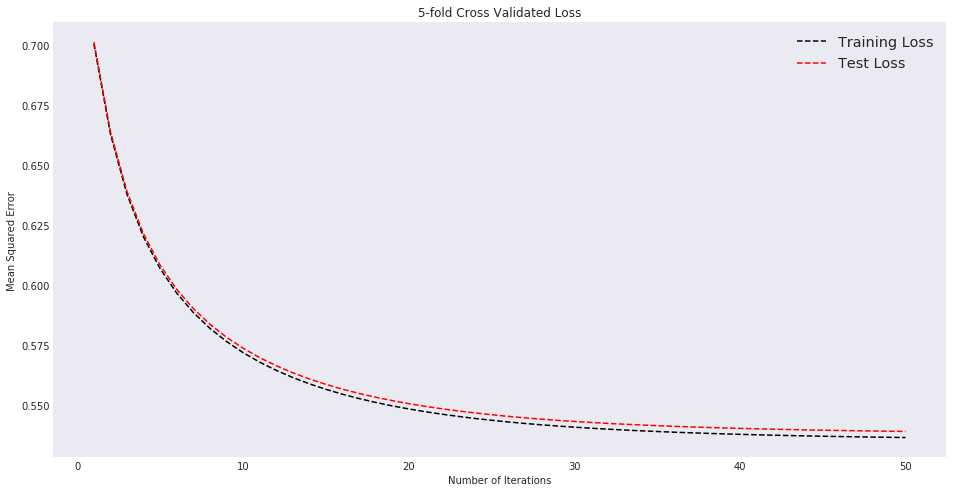

In [112]:
# part d - take a look (RUN THIS CELL AS IS)
plotErrorCurves(trainLoss, testLoss, title = '5-fold Cross Validated Loss' )

# Question 7: Regularization.

Our goal, as always, is to build a linear model that will extend well to unseen data. Chosing the right combination of features to optimize generalizability can be extremely computationally costly given that there are $2^{p}$ potential models that can be built from $p$ features. Traditional methods like forward selection would involve iteratively testing these options to asses which combinations of features achieve a statistically significant prediction.

Ridge Regression and Lasso Regression are two popular alternatives to OLS, which enable us to train generalizable models without the trouble of forward selection and/or manual feature selection.  Both methods take advantage of the bias-variance tradeoff by _shrinking_ the model coefficients towards 0 which reduces the variance of our model with little increase in bias. In practice this 'shrinkage' is achieved by adding a penalty (a.k.a. 'regularization') term to the means squared error loss function. In this question you will implement Gradient Descent with ridge and lasso regularization.

__`IMPORTANT NOTE:`__ When performing regularization _do not_ include the bias in your regularization term calcultion (Recall, that throughout this assignment we've included the bias at index 0 in the vector of weights that is your model).

### Q7 Tasks:
* __a) short response:__ The regularization term for ridge regression is the square of the $L2$ norm of the weights vector (i.e. the sum of squares of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Ridge Regularization and explain what extra step this will add to our gradient descent algorithm.


* __b) short response:__ The regularization term for lasso regression is the $L1$ norm of the weights vector (i.e. the sum of the absolute values of the coefficients) times the regularization parameter, $\lambda$. Write the formulas for both the loss function and the gradient for Lasso Regularization and explain how the gradient descent update in Lasso will be different than it was in Ridge.


* __c) code:__ Fill in the first two missing code blocks in `GDUpdate_wReg()` so that this function will perform a single parameter update using $L2$ regularization if the parameter `regType` is set to `ridge`, $L1$ regularization if set to `lasso` and unregularized OLS otherwise.


* __d) code + short response:__ Use the provided code to train 50 iterations of ridge and lasso regression and plot the test/train error. Comment on the curves you see. Does this match your expectation?

### Q7 Student Answers:
> __a)__ For ridge regularization, the loss function is $f(\boldsymbol{\theta})=\frac{1}{n}\sum_{i=1}^{n}\left[\boldsymbol{\theta}\cdot\mathbf{x}'_{i}-y_{i}\right]^{2}+\lambda|\boldsymbol{|\theta}||^{2}$ and the gradient is $\nabla_{\boldsymbol{\theta}}f(\boldsymbol{\theta})=\frac{2}{n}\,\sum_{i=1}^{n}\left[\boldsymbol{\theta}\cdot\mathbf{x}'_{i}-y_{i}\right]\cdot\mathbf{x}'+\lambda\boldsymbol{\theta}$.  When ridge regularization adds one extra step in the gradient descent algorithm.  To calculate each model version, we not only subtract the gradient with no regularization (the features vector weighted by loss average) but also the regularization gradient term, which is the product of the regularization parameter and the model vector.  

> __b)__ For lasso regularization, the loss function is $f(\boldsymbol{\theta})=\frac{1}{n}\sum_{i=1}^{n}\left[\boldsymbol{\theta}\cdot\mathbf{x}'_{i}-y_{i}\right]^{2}+\lambda||\boldsymbol{\theta}||$ and the gradient is $\nabla_{\boldsymbol{\theta}}f(\boldsymbol{\theta})=\frac{2}{n}\,\sum_{i=1}^{n}\left[\boldsymbol{\theta}\cdot\mathbf{x}'_{i}-y_{i}\right]\cdot\mathbf{x}'+\lambda(\boldsymbol{1_{>0}}(\boldsymbol{\theta})*2-1)$.  Lasso regularization is different because the regulaization term in the gradient is a different vector.  Unlike ridge regularization which uses the model (weight) vector times regularization parameter as the additional term in the gradient, the lasso regularization uses a modified vector of -1s and 1s times the regularization parameter as the additional term in the gradient.  This modified vector 1 for every model paramter that is greater than 0, and a -1 for all parameter values 0 or less.  Lasso regularization appears to penalize some model parameters much more heavily as it can set some of the parameters in the model to 0.  Graphically, this would mean that each gradient descent step using lasso regularization would go in a slightly different direction than that of ridge regularization, and the distance of the step using either regularization is different in the parameter domain space.  In the larger scheme of the gradient descent method however, the steps might go in different directions each iteration, the overall general direction of gradient descent using either regularization should head towards the global minimum in the error surface. 

> __d)__ With ridge regularization, the curves appear smooth and the training loss and test loss are very similar. The appearance of the ridge regularization loss curves resemble our result in #6 where we performed cross validation. This does match our expectataion as the ridge regularization term is meant to produce a model with better generalizability, which means that the resulting model should have very similar test and training loss. Unlike ridge regularization, the curves plotted from lasso regularization are jagged in the asymptotic region for later iterations.  The loss is still approaching a minimum, but there is some fluctuation away from the asymptote.  The fluctuations for the test loss is more pronounced than that of the training loss.  The lasso regularization is more used for features selection as it penalizes some model parameters very heavily, potentially setting them to 0 or changing their sign, especially in later steps as the gradient descent path gets closer and closer to the minimum.  These fluctuations to the model coefficients are more dramatic than that of ridge regularization gradient descent, which also causes the loss calculations to fluctuate more dramatically.  Given that the test data set is much smaller than the training data set, the fluctuations in error for the test data is more pronounced, since there is increased variability. 

In [92]:
# part c - gradient descent with regularization
def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):
    """
    Perform one gradient descent step/update with ridge or lasso regularization.
    Args:
        dataRDD - tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
        learningRate - (float) defaults to 0.1
        regType - (str) 'ridge' or 'lasso', defaults to None
        regParam - (float) regularization term coefficient
    Returns:
        model   - (array) updated coefficients, bias still at index 0
    """
    # augmented data
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    new_model = None
    #################### YOUR CODE HERE ###################
    
    if regType == 'ridge':
        wregr = W*1
        wregr[0] = 0 #first value of weight vecotr is the bias term which should be excluded from regularization.
        grad = augmentedData.map(lambda x: (np.dot(W, x[0]) - x[1])*x[0]+regParam*wregr)\
                            .reduce(lambda x,y: x + y)*2/(augmentedData.count())
    elif regType == 'lasso':
        wregl = W*1
        wregl[0] = 0 #first value of weight vecotr is the bias term which should be excluded from regularization.
        wregl = (wregl>0).astype(int)*2-1
        grad = augmentedData.map(lambda x: (np.dot(W, x[0]) - x[1])*x[0]+regParam*wregl)\
                            .reduce(lambda x,y: x + y)*2/(augmentedData.count())
    else:
        grad = augmentedData.map(lambda x: (np.dot(W, x[0]) - x[1])*x[0])\
                            .reduce(lambda x,y: x + y)*2/(augmentedData.count())
    
    new_model = W-learningRate*grad

    ################## (END) YOUR CODE ####################
    return new_model

In [84]:
# part d - ridge/lasso gradient descent function
def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
    """
    Perform nSteps iterations of regularized gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        # update the model
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        # keep track of test/train loss for plotting
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [85]:
# run 50 iterations of ridge (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )
print(f"\n... trained {len(ridge_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 46.11493229866028 seconds


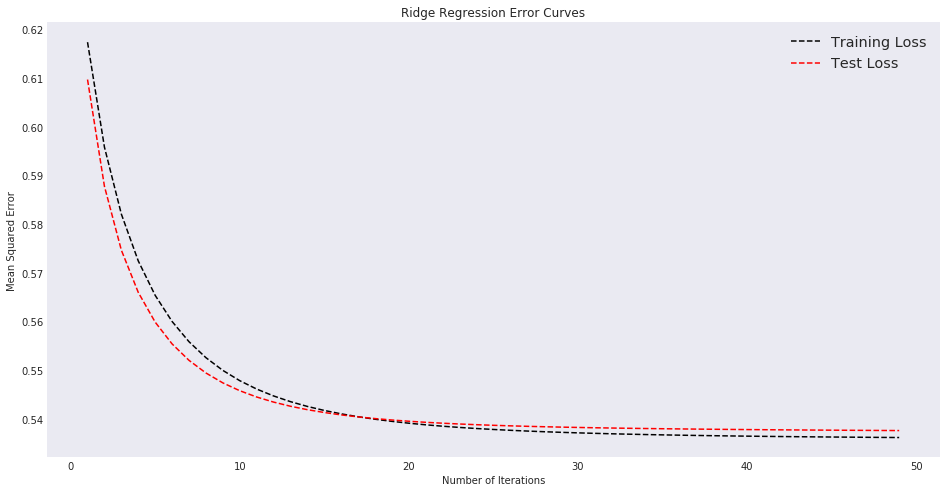

In [86]:
# part d - save and display ridge results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = ridge_results
np.savetxt(PWD + '/data/ridge_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/ridge_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Error Curves' )

In [93]:
# run 50 iterations of lasso (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 5)
start = time.time()
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)
print(f"\n... trained {len(lasso_results[2])} iterations in {time.time() - start} seconds")


... trained 50 iterations in 60.89384865760803 seconds


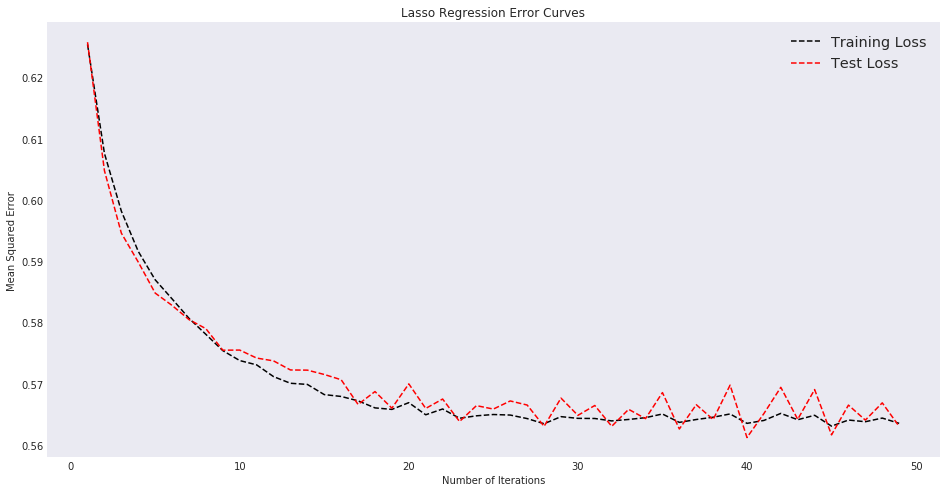

In [94]:
# part d - save and display lasso results (RUN THIS CELL AS IS)
trainLoss, testLoss, models = lasso_results
np.savetxt(PWD + '/data/lasso_models.csv', np.array(models), delimiter=',')
np.savetxt(PWD + '/data/lasso_loss.csv', np.array([trainLoss, testLoss]), delimiter=',')
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Error Curves' )

# Question 8: Results

In this final question we'll use a few different plots to help us compare the OLS, Ridge and Lasso models that we have trained. Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method.

### Q8 Tasks:
* __a) code:__ Use the provided code to load the training history from file and retrieve the best (i.e. last) model from each method. Then compute the mean squared error on the held out dataset for each of the three models. [__`TIP:`__ _the held out data is in it's raw form, don't forget to parse and normalize before applying your calculations, you should also be careful to normalize using the same scaling parameters that you used for the training data._]

* __b) short response:__ Which model performed best? Discuss how you interpret these results and what you would want to try next.


* __c) short response:__ Use the provided code to plot side by side boxplots of the residuals vs. the outcome (i.e. `quality`). What can you observe about our model performance? [__`TIP:`__ _note that the heldout data set is plenty small enough to fit in memory so no need to sample. Feel free to do your plotting in pandas or any other comfortable python package._]


* __d) short response:__ Run the provided code to visualize the model coefficients for the first 50 iterations of training. What do you observe about how the OLS, ridge and lasso coefficients change over the course of the training process. Please be sure to discuss all three in your response.

### Q8 Student Answers:
> __b)__ The OLS model with no regularization performed best but the mean squared error of the model is only slightly less than that of the model with ridge regularization.  The ridge regularization model outperforms the lasso regularization model by a lot more, and this is expected since ridge regularization allows the model to generalize better to new data points.  I do question the performance of the OLS model, however, as the MSE measurement is partially due to chance, based on how data was split to create the held out data set.  We may want to run the same cross validation analysis on the OLS model with no regularization, by replitting the original data into training and heldout sets, just to prove that ridge regularization is absolutely essential.  To find the best possible model, we can also consider doing a combination of both regularizations.  Perhaps we first create a model using lasso regularization as a form of feature selection, then use ridge regularization on the output to enhance regularization.   

> __c)__ The prediction error and quality score have a clear positive relationship.  For each quality score, the box plots for prediction error are extremely similar between OLS and ridge.  There are some noticeable differences between lasso and the other two. 

> __d)__ The behavior of the majority of coefficients as the iterations increase are similar for both OLS and ridge models.  The majority of coefficients smoothly asymptotically approach a certain value as the number of iterations increase or as the gradient descent path approaches 0. The asymptotic value for each coefficient is different between OLS and ridge, but the difference is small.  Unlike both models, the lasso coefficients clearly displays feature selection behavior.  The majority of the the lasso coefficients approach 0 as the number of iterations increase, and once reaching 0, the coefficients then fluctuate around 0 through this jagged behavior indicating that their changes are still noticeable with each iteration.  Only 3 of the 11 coefficients asympotically approach a non-zero value, indicating that they might be the most important in terms of explaning the variability in the outcome quality variable. 

In [96]:
# part a - load the models from file (RUN THIS CELL AS IS)
ols_models = np.loadtxt(PWD + '/data/OLSmodels.csv', dtype=float, delimiter=',')
ridge_models = np.loadtxt(PWD + '/data/ridge_models.csv', dtype=float, delimiter=',')
lasso_models = np.loadtxt(PWD + '/data/lasso_models.csv', dtype=float, delimiter=',')
best_ols = ols_models[-1,:]
best_ridge = ridge_models[-1,:]
best_lasso = lasso_models[-1,:]

In [98]:
# part a - compute MSE on the held out data for all three 'best' models
olsMSE, ridgeMSE, lassoMSE = None, None, None
############### YOUR CODE HERE #################
#parse the held out data
heldOutRDDCached = heldOutRDD.map(parse).cache()
#normalize
normedheldRDD = normalize(heldOutRDDCached).cache()

#calculate losses
olsMSE =  OLSLoss(normedheldRDD, best_ols)
ridgeMSE = OLSLoss(normedheldRDD, best_ridge)
lassoMSE = OLSLoss(normedheldRDD, best_lasso)

############### YOUR CODE HERE #################

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5528930634616994
Ridge Mean Squared Error: 0.5537596774368002
Lasso Mean Squared Error: 0.5750245037865497


In [99]:
# part c - helper function (RUN THIS CELL AS IS)
def get_residuals(dataRDD, model):
    """
    Return a collected list of tuples (residual, quality_score)
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    residuals = augmentedData.map(lambda x: (x[1] - model.dot(x[0]), x[1]))
    return residuals.collect()

In [100]:
# part c - compute residuals for all three models (RUN THIS CELL AS IS)
ols_resid = np.array(get_residuals(normedheldRDD, best_ols))
ridge_resid = np.array(get_residuals(normedheldRDD, best_ridge))
lasso_resid = np.array(get_residuals(normedheldRDD, best_lasso))

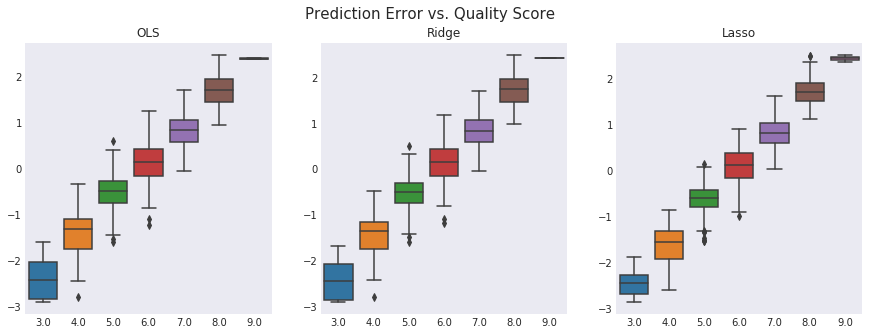

In [101]:
# part c - boxplots of residuals for all three models (RUN THIS CELL AS IS)
fig, axes = plt.subplots(1, 3, figsize=(15,5))
stuff_to_plot = zip(axes, ["OLS", "Ridge", "Lasso"], [ols_resid, ridge_resid, lasso_resid])
for ax, title, data in stuff_to_plot:
    ax.set_title(title)
    y = data[:, 0]
    x = data[:, 1]
    sns.boxplot(x, y, ax=ax)
fig.suptitle("Prediction Error vs. Quality Score", fontsize=15, y=0.98)
plt.show()

In [102]:
# part d - plotting function (RUN THIS CELL AS IS)
def plotCoeffs(models, featureNames, title):
    """
    Helper Function to show how coefficients change as we train.
    """
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data, name in zip(models.T, featureNames):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    plt.show

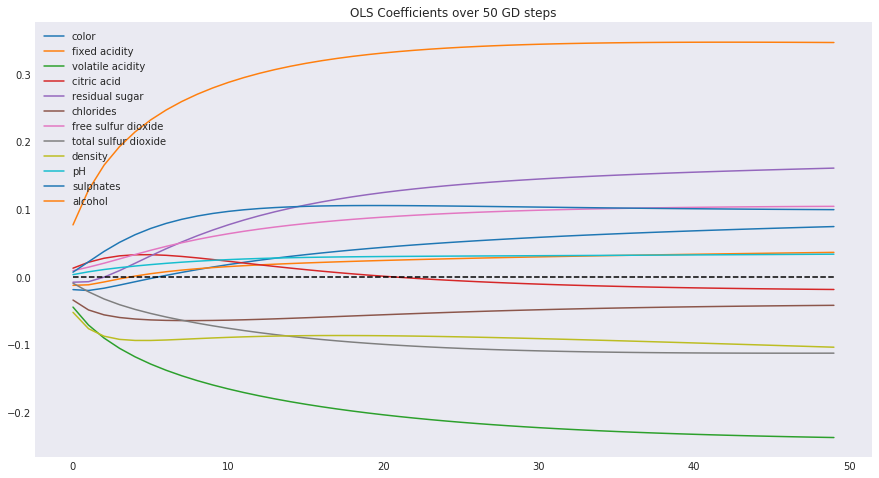

In [103]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ols_models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

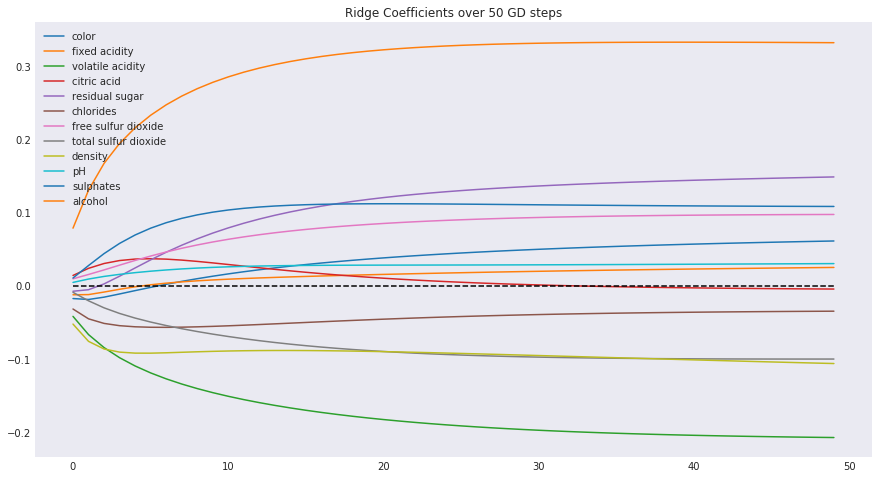

In [104]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

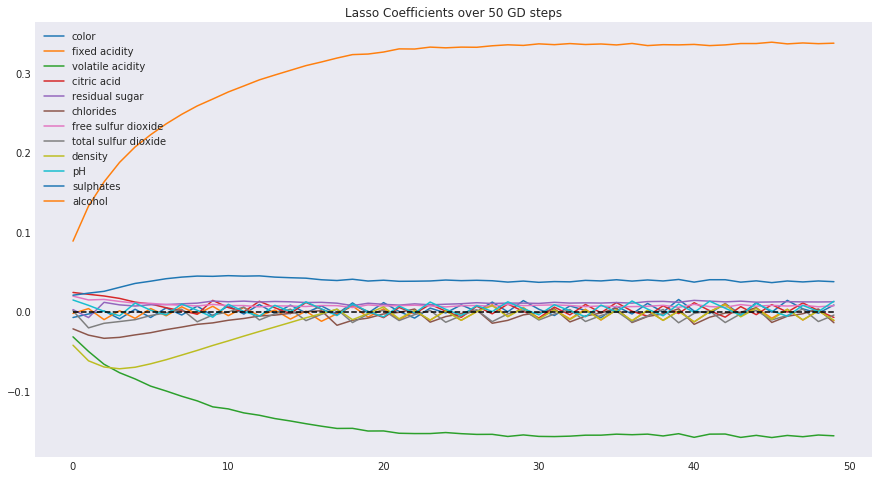

In [105]:
# take a look (RUN THIS CELL AS IS)
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

### Congratulations, you have completed HW4! Please refer to the readme for submission instructions.